In [111]:
import argparse
import datetime
import pickle
from collections import defaultdict
from functools import partial
from pathlib import Path
from typing import Tuple

import jax
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import ot
import seaborn as sns
import torch
import pyro
#from easydict import EasyDict as edict
from matplotlib.colors import LinearSegmentedColormap
from pyro.infer import HMC, MCMC, NUTS
from scipy.stats import gaussian_kde
from tqdm import tqdm
#from utils import DotConfig

from sampling_utils.adaptive_mc import CISIR, Ex2MCMC, FlowMCMC
from sampling_utils.adaptive_sir_loss import MixKLLoss
from sampling_utils.distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)
from sampling_utils.ebm_sampling import MALA
from sampling_utils.flows import RNVP
from sampling_utils.metrics import ESS, acl_spectrum
from sampling_utils.total_variation import (
    average_total_variation,
)

In [112]:
sns.set_theme(style="ticks", palette="deep")

In [113]:
def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument("config", type=str)
    parser.add_argument("--dist_config", type=str)
    parser.add_argument("--result_path", type=str)
    # parser.add_argument('--dims', type=int, nargs='+')
    # parser.add_argument
    args = parser.parse_args()

    return args


def main(config, run=True):
    device = config.device
    method_metric_dict = defaultdict(lambda: defaultdict(list))

    if run:
        for dim in config.dims:
            dist_class = eval(config.dist_class)
            target = dist_class(
                dim=dim,
                device=device,
                **config.dist_params.dict,
            )

            loc_proposal = torch.zeros(dim).to(device)
            scale_proposal = config.scale_proposal * torch.ones(dim).to(device)
            proposal = IndependentNormal(
                dim=dim,
                loc=loc_proposal,
                scale=scale_proposal,
                device=device,
            )

            print("========== NUTS ==========")
            samples_true = sample_nuts(
                target,
                proposal,
                num_samples=10000,#config.trunc_chain_len,
                batch_size=1, #config.batch_size
            )[:, 0, :]

            sample = sample_nuts(
                target,
                proposal,
                num_samples=config.trunc_chain_len,
                batch_size=config.batch_size,
                burn_in=config.trunc_chain_len,
            )

            metrics = compute_metrics(
                    samples_true,
                    sample,
                    name='NUTS',
                    trunc_chain_len=config.trunc_chain_len,
                    ess_rar=1,
                )
            for k, v in metrics.items():
                method_metric_dict['NUTS'][k] = list(
                    method_metric_dict['NUTS'][k],
                )
                method_metric_dict['NUTS'][k].append(v)

            #sample = samples_true #[-config.trunc_chain_len :]
            #print(target(torch.from_numpy(np.stack(sample, 0))).mean())
            samples = [sample[:, 0, :]]
            names = []
            colors = []
            for method_name, info in config.methods.items():
                colors.append(info.color)
                names.append(method_name)
                print(f"========== {method_name} =========== ")
                params = info.params
                try:
                    mcmc_class = eval(info.mcmc_class)
                except KeyError:
                    print("Can't understand class")

                params = params.dict
                if "lr" in params:
                    params["lr"] = eval(params["lr"])

                mcmc = mcmc_class(**params, dim=dim)

                if "flow" in info.dict.keys():
                    verbose = mcmc.verbose
                    mcmc.verbose = False
                    flow = RNVP(info.flow.num_flows, dim=dim)

                    flow_mcmc = FlowMCMC(
                        target,
                        proposal,
                        flow,
                        mcmc,
                        batch_size=info.flow.batch_size,
                        lr=info.flow.lr,
                    )
                    flow.train()
                    out_samples, nll = flow_mcmc.train(
                        n_steps=info.flow.n_steps,
                    )
                    assert not torch.isnan(
                        next(flow.parameters())[0, 0],
                    ).item()

                    flow.eval()
                    mcmc.flow = flow
                    mcmc.verbose = verbose

                    if "figpath" in config.dict:
                        fig = plot_learned_density(
                            flow,
                            proposal,
                            xlim=target.xlim,
                            ylim=target.ylim,
                        )
                        plt.savefig(
                            Path(
                                config.figpath,
                                f"flow_{config.dist}_{dim}.pdf",
                            ),
                        )
                        plt.close()

                start = proposal.sample((config.batch_size,))

                # s = time.time()
                out = mcmc(start, target, proposal, n_steps=info.n_steps)
                print(mcmc.grad_step)
                # e = time.time()
                # elapsed = (e - s)
                if isinstance(out, tuple):
                    sample = out[0]
                else:
                    sample = out

                sample = np.array(
                    [_.detach().numpy() for _ in sample],
                ).reshape(-1, config.batch_size, dim)

                metrics = compute_metrics(
                    samples_true,
                    sample,
                    name=method_name,
                    trunc_chain_len=config.trunc_chain_len,
                    ess_rar=info.ess_rar,
                )
                for k, v in metrics.items():
                    method_metric_dict[method_name][k] = list(
                        method_metric_dict[method_name][k],
                    )
                    method_metric_dict[method_name][k].append(v)

                sample = sample[-config.trunc_chain_len:, 0]

                #print(target(torch.from_numpy(np.stack(sample, 0))).mean())
                samples.append(sample)

                if "figpath" in config.dict:
                    SMALL_SIZE = 18  # 8
                    MEDIUM_SIZE = 20  # 10
                    BIGGER_SIZE = 20  # 12

                    plt.rc(
                        "font", size=SMALL_SIZE
                    )  # controls default text sizes
                    plt.rc(
                        "axes", titlesize=BIGGER_SIZE
                    )  # fontsize of the axes title
                    plt.rc(
                        "axes",
                        labelsize=MEDIUM_SIZE,
                    )  # fontsize of the x and y labels
                    plt.rc(
                        "xtick",
                        labelsize=SMALL_SIZE,
                    )  # fontsize of the tick labels
                    plt.rc(
                        "ytick",
                        labelsize=SMALL_SIZE,
                    )  # fontsize of the tick labels
                    plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
                    plt.rc(
                        "figure",
                        titlesize=BIGGER_SIZE,
                    )  # fontsize of the figure title

            for i, (name, sample) in enumerate(zip(['NUTS']+names, samples)):
                # fig, axs = plt.subplots(ncols=len(names), figsize=(24, 8))
                fig, ax = plt.subplots(1, 1, figsize=(5,5)) #(4, 4))
                ax.scatter(
                    sample[:config.trunc_chain_len, 0],
                    sample[:config.trunc_chain_len, 1],
                    alpha=0.3,
                    s=2,
                    color="black",
                )

                if i == 0:
                    xlim = ax.get_xlim()
                    ylim = ax.get_ylim()
                    
                    # xlim = (0, xlim[1])
                    # ax.set_xlim(*xlim)
                else:
                    ax.set_xlim(*xlim)
                    ax.set_ylim(*ylim)

                target.plot_2d(fig, ax)

                # plt.axis('equal')

                ax.set_box_aspect(1)
                ax.xaxis.set_tick_params(labelsize=15)
                ax.yaxis.set_tick_params(labelsize=15)
                #ax.axis('off')

                plt.title(name)

                plt.savefig(
                    Path(
                        config.figpath,
                        fr"{config.dist}_{dim}_{name}_proj.pdf",
                    )
                )
                plt.close()

        sub = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M")

        if "respath" in config.dict:
            method_metric_dict = dict(method_metric_dict)
            resdir = Path(config.respath, config.dist)
            resdir.mkdir(parents=True, exist_ok=True)
            respath = Path(resdir, f"{sub}.npy")
            pickle.dump(method_metric_dict, respath.open("wb"))
            # method_metric_dict = pickle.load(respath.open('rb'))

    else:
        method_metric_dict = pickle.load(Path(config.respath).open("rb"))
        colors = []
        for method_name, info in config.methods.items():
            colors.append(info.color)

    if "figpath" in config.dict:
        SMALL_SIZE = 18  # 8
        MEDIUM_SIZE = 20  # 10
        BIGGER_SIZE = 20  # 12

        plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
        plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
        plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
        plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
        plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
        plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
        plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

        Path(config.figpath, f"{config.dist}").mkdir(exist_ok=True)
        plot_metrics(
            method_metric_dict,
            config.dims,
            savepath=Path(config.figpath, f"{config.dist}"),
            colors=colors,
        )
        # plt.savefig(Path(config.figpath, '{config.dist}_proj.png'))

In [114]:
def sample_nuts(target, proposal, num_samples=1000, burn_in=1000, batch_size=1):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()

    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(45)
    init_samples = proposal.sample((batch_size,))
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = np.array(q_true.view(-1, batch_size, dim))

    return samples_true


def plot_hist(
    samples,
    title="Histogram",
    bins=200,
    gamma=0.5,
    dims=[0, 1],
    ax_lims=[(-2, 9), (-2, 4)],
    save_path="pics/histogram_test.pdf",
    density=True,
):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(
        samples[:, dims[0]],
        samples[:, dims[1]],
        bins=bins,
        density=density,
        range=[ax_lims[0], ax_lims[1]],
        norm=mcolors.PowerNorm(gamma),
    )
    plt.title(title)
    plt.axis("off")
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

In [115]:
def plot_learned_density(
    flow,
    proposal,
    fig=None,
    device="cpu",
    xlim=[-1, 1],
    ylim=[-1, 1],
    rest=0.0,
):
    if fig is None:
        fig = plt.figure()
    n_pts = 200
    z = proposal.sample((n_pts**2,))
    x = np.linspace(*xlim, n_pts)
    y = np.linspace(*ylim, n_pts)
    xx, yy = np.meshgrid(x, y)
    zz = np.stack([xx, yy], -1)
    z[:, :2] = torch.FloatTensor(zz).view(-1, 2).to(device)
    z[:, 2:] = torch.FloatTensor([rest] * n_pts**2)[:, None]

    inv, minus_log_jac = flow.inverse(z)
    minus_log_jac = minus_log_jac.reshape(n_pts, n_pts)
    inv = inv.reshape(n_pts, n_pts, -1)
    vals = (proposal(inv) + minus_log_jac).exp().detach()

    im = plt.contourf(xx, yy, vals.reshape(n_pts, n_pts), cmap="GnBu")
    fig.colorbar(im)
    return fig

def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 15
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b] / scale)
        emd = ot.lp.emd2([], [], M)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [116]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.0, colors=None):
    axs_names = ["Sliced TV", "ESS", "EMD ratio"]  # (on scaled data)']
    ncols = len(axs_names)

    figs = []
    axs = []
    for _ in range(ncols):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        figs.append(fig)
        axs.append(ax)

    mala_emd = metrics['MALA']['emd']
    
    for (name, res), color in zip(metrics.items(), colors):
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res["tv_mean"]
        axs[0].plot(ndims, arr, label=name, marker="o", color=color)

        axs[0].fill_between(
            ndims,
            res["tv_mean"] - 1.96 * res["tv_conf_sigma"],
            res["tv_mean"] + 1.96 * res["tv_conf_sigma"],
            alpha=0.2,
        )

        arr = res["ess"]
        axs[1].plot(ndims, arr, label=name, marker="o", color=color)

        if name != 'MALA':
            arr = mala_emd / res["emd"]
            axs[2].plot(ndims, arr, label=name, marker="o", color=color)
        #axs[2].set_yscale("log")

    for ax, fig, name in zip(axs, figs, axs_names):
        ax.grid()
        ax.set_title(name.split(' ')[0])
        ax.set_xlabel("dim")
        if name == "EMD ratio":
            ax.legend()

        fig.tight_layout()

        if savepath is not None:
            fig.savefig(Path(savepath, f"{name}.pdf"))

In [117]:
def funnel_dens_2d(x):
    """
    returns 2-dimensional funnel distribution density
    """
    logprob_1 = -x[0]**2 / 2
    logprob_2 = -0.5*np.exp(-x[0])*(x[1]**2) -0.5*x[0]
    return logprob_1+logprob_2

In [118]:
n_steps = 1
dist = "funnel"
dim = 10
scale_target = 1.
scale_proposal = 2.
dist_class = "Funnel"
dist_params = {
    "a": 1.0,
    "b": 0.5
}
a = 2.0
b = 0.5

In [119]:
device = 'cpu'
method_metric_dict = defaultdict(lambda: defaultdict(list))

In [77]:
#target = Funnel(
#                dim=dim,
#                device=device,
#                a = a,
#                b = b
                #**dist_params.dict,
#)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_target = scale_target * torch.ones(dim).to(device)
proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

target = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_target,
    device=device,
)

### Generate ground-truth samples

In [78]:
N_samples = 2*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
True_samples[:,0] *= a 
for i in range(1,dim):
    True_samples[:,i] *= np.exp(True_samples[:,0]/2) 

In [79]:
"""
a = 2.0
N_pts = 100
xlist = np.linspace(-a, 3*a, 100)
ylist = np.linspace(-2*a, 3*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = funnel_dens_2d(points[:,i,j])
"""

'\na = 2.0\nN_pts = 100\nxlist = np.linspace(-a, 3*a, 100)\nylist = np.linspace(-2*a, 3*a, 100)\nX, Y = np.meshgrid(xlist, ylist)\npoints = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)\npoints[0] = X\npoints[1] = Y\ndens_vals = np.zeros_like(X)\nfor i in range(N_pts):\n    for j in range(N_pts):\n        dens_vals[i,j] = funnel_dens_2d(points[:,i,j])\n'

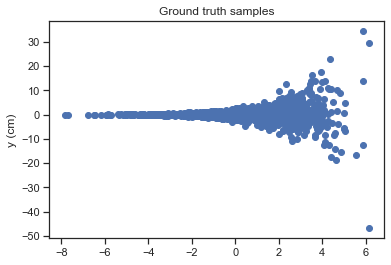

In [80]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1])
ax.set_title('Ground truth samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with NUTS

In [81]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [82]:
#samples_true = sample_nuts(
#                target,
#                proposal,
#                num_samples=Nuts_samples_ground_truth,#config.trunc_chain_len,
#                batch_size=nuts_batch, #config.batch_size
#)[:, 0, :]
#print(samples_true.shape)

In [83]:
sample_nuts_ref = sample_nuts(
                target,
                proposal,
                num_samples=trunc_chain_len,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
)
print(sample_nuts_ref.shape)

torch.Size([1, 10])


Sample: 100%|█| 1500/1500 [00:01, 845.34it/s, step size=7.53e-01, acc. prob=0.87

(1000, 1, 10)


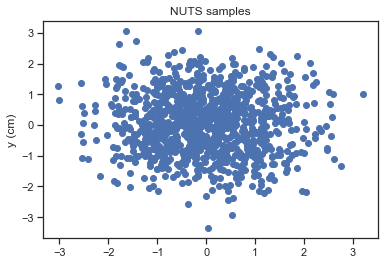

In [84]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1])
ax.set_title('NUTS samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [85]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.189, Std: 0.038. 
ESS: 0.374 
EMD: 49.257


### Sample with Ex2MCMC

In [132]:
params = {
      "N": 1,
      "grad_step": 0.2,
      "adapt_stepsize": False, #True
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0, #0.75
      "mala_steps": 5
}
        
n_steps_ex2 = 1000
batch_size = 1

In [133]:
mcmc = Ex2MCMC(**params, dim=dim)
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_ex2)
print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_ex2_final = sample[:,0,:]
print(sample_ex2_final.shape)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 597.59it/s]

tensor([0.9216])
(1000, 10)


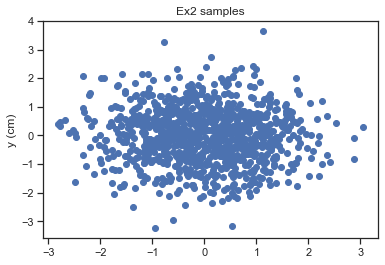

In [134]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1])
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [135]:
metrics = compute_metrics(
                    True_samples,
                    sample,
                    name="Ex2MCMC",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

====Ex2MCMC====
TV distance. Mean: 0.195, Std: 0.045. 
ESS: 0.312 
EMD: 48.976


### Sample with Flex2MCMC (adaptive version)

In [136]:
params_flex = {
      "N": 20,
      "grad_step": 0.2,
      "adapt_stepsize": False,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_flows": 3, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 1000,
    }
}

In [137]:
pyro.set_rng_seed(42)
mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_flows"], dim=dim)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()

flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 81.92it/s]


In [138]:
print(nll)

[17.125240325927734, 15.581430435180664, 15.35763168334961, 14.913264274597168, 14.844963073730469, 14.794836044311523, 14.571760177612305, 14.54067611694336, 14.322901725769043, 14.403083801269531, 14.562422752380371, 14.4896821975708, 14.167149543762207, 14.24804401397705, 14.32513427734375, 14.458484649658203, 14.664759635925293, 14.469200134277344, 14.405077934265137, 14.318848609924316, 14.638646125793457, 14.353560447692871, 14.207006454467773, 14.098204612731934, 14.443650245666504, 14.101104736328125, 14.27823257446289, 14.03512954711914, 14.094067573547363, 14.035270690917969, 14.628927230834961, 14.526202201843262, 14.482708930969238, 14.195717811584473, 14.478649139404297, 14.29306411743164, 14.08102798461914, 14.35363483428955, 14.35470199584961, 13.960319519042969, 14.316607475280762, 14.292071342468262, 13.968520164489746, 14.28332805633545, 14.227355003356934, 14.188464164733887, 13.912846565246582, 14.255404472351074, 14.121971130371094, 14.187960624694824, 14.081336975

In [142]:
#sample from a normalizing flow
n_steps_flex2 = 1000
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
mcmc.N = 10
mcmc.mala_steps = 0
mcmc.grad_step = 0.1
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_flex2_new = sample
#resample with 0 mala steps
mcmc.mala_steps = 5
out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new
print(sample_flex2_final.shape)

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 400.94it/s]

(1000, 1, 10)


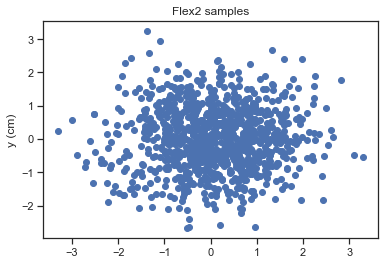

In [143]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,5])
ax.set_title('Flex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

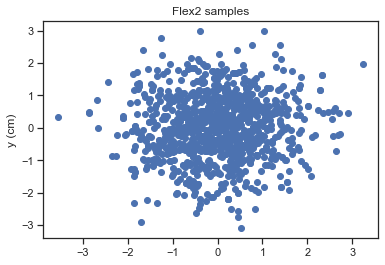

In [144]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1])
ax.set_title('Flex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

In [97]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.193, Std: 0.040. 
ESS: 0.523 
EMD: 49.232


In [98]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_new,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.194, Std: 0.036. 
ESS: 0.474 
EMD: 49.147


In [ ]:
print(np.sum(True_samples[:,0] < -2))
print(np.sum(sample_nuts_ref[:,0,0] < -2))
print(np.sum(sample_flex2_final[:,0,0] < -2))

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e',label = "True samples")
ax[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex$^2$MCMC, 5 MALA steps")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e',label = "True samples")
ax[1].scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1],c='#1f77b4',label = "Flex$^2$MCMC, no MALA steps")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=14)
plt.savefig(Path(
        "./",
        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
        ), format="pdf", bbox_inches="tight") 
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax = sns.kdeplot(x=True_samples[:,0],label = "True samples")
ax = sns.kdeplot(x=sample_flex2_final[:,0,0],label = "Flex$^2$MCMC, 5 MALA steps")
ax = sns.kdeplot(x=sample_flex2_new[:,0,0],label = "Flex$^2$MCMC, no MALA steps")
plt.legend(loc ="upper left",fontsize=14)
plt.savefig(f"flow_dim_{dim}_density_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e',label = "True samples")
ax[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=16)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e',label = "True samples")
ax[1].scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1],c='#1f77b4',label = "NUTS samples")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=16)
plt.savefig(Path(
        "./",
        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
        ), format="pdf", bbox_inches="tight") 
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.kdeplot(x=True_samples[:,0],label = "True samples")
ax = sns.kdeplot(x=sample_flex2_final[:,0,0],label = "Flex$^2$MCMC ")
ax = sns.kdeplot(x=sample_nuts_ref[:,0,0],label = "NUTS")
plt.legend(loc = "upper left",fontsize=16)
plt.savefig(f"flow_dim_{dim}_density_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.kdeplot(x=True_samples[:,1],label = "True samples KDE")
ax = sns.kdeplot(x=sample_flex2_final[:,0,1],label = "Flex$^2$MCMC samples KDE")
ax = sns.kdeplot(x=sample_nuts_ref[:,0,1],label = "NUTS samples KDE")
plt.legend(loc = "upper right",fontsize=12)
#plt.savefig(f"flow_dim_{dim}_density_var_2.pdf",format="pdf", bbox_inches="tight")
plt.show()